# Data Analysis and Visualization - 094295
## HW 2 - Box Office Revenue Prediction
## Nitzan Shamir 206348187 & Omer Shubi 312236219

Link to GitHub repository - [094295_hw2](https://github.com/scaperex/094295_hw2)

In this project we have two main tasks.

The first is to perform explanatory data analysis (EDA).

In the second is to perform prediction for the bounding box and the label of the box of each image in different experiments.

Note, we hide the code cells so that the notebook stays clean. The full code is in the included in the repository.

## EDA

In this phase we explore the data. We perform a basic analysis of the data, we visualize some images and provide insights from the data.

In [1]:
import os
from utils import parse_data_for_vis
import config as cfg
import pandas as pd
import numpy as np
import random
import torchvision
import torch
import matplotlib.pyplot as plt
from matplotlib import patches
import cv2

In [27]:
def parse_data(data_dir):
    filenames = os.listdir(data_dir)
    data = parse_data_for_vis(filenames)
    data = pd.DataFrame(data, columns=['fileName', 'id', 'bbox', 'label'])
    bbox_data = pd.DataFrame(data["bbox"].to_list(), columns=['x', 'y', 'w', 'h'])
    data = pd.concat([data ,bbox_data], axis=1)
    data["box_area"] =  data["w"] * data["h"]
    data["type"] = data_dir
    data["imageWidth"] = data.apply(lambda x: torchvision.io.read_image(os.path.join(x.loc['type'], x.loc["fileName"])).shape[1], axis=1)
    data["imageHeight"] = data.apply(lambda x: torchvision.io.read_image(os.path.join(x.loc['type'], x.loc["fileName"])).shape[2] , axis=1)
    return data

In [3]:
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=(15,15))
    for i, img in enumerate(imgs):
        img = img.detach()
        img = torchvision.transforms.functional.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [4]:
def show_images(image_dir):
    filenames = random.sample(os.listdir(image_dir), 64)
    transformer = torchvision.transforms.Resize([224,244])
    images = [transformer(torchvision.io.read_image(os.path.join(image_dir, filename))) for filename in filenames]
    grid = torchvision.utils.make_grid(images)
    show(grid)

In [5]:
def show_images_and_bboxes(image_dir):
    filenames = random.sample(os.listdir(image_dir), 3000)
    data = parse_data_for_vis(filenames)
    images_with_bbox = []
    bboxs = []
    counter = 0
    for indx, (filename, image_id, bbox, proper_mask) in enumerate(data):
        img = torchvision.io.read_image(os.path.join(image_dir, filename))
        if img.shape == torch.Size([3, 224, 224]):
            x1, y1, w1, h1 = bbox 
            bbox[cfg.x2_inx] = bbox[cfg.x1_inx] + bbox[cfg.w_inx]
            bbox[cfg.y2_inx] = bbox[cfg.y1_inx] + bbox[cfg.h_inx]
            bbox = [bbox]
            bbox = torch.tensor(bbox)
            color = "green" if proper_mask else "red"
            images_with_bbox.append(torchvision.utils.draw_bounding_boxes(img, bbox, width=5, colors=[color]))
            counter += 1
        if counter > 63:
            break
    grid = torchvision.utils.make_grid(images_with_bbox)
    show(grid)

In [28]:
data = pd.concat([parse_data(cfg.train_dir) ,parse_data(cfg.val_dir)])
data

fileName      id                 bbox  \
0         000193__[6, 70, 87, 85]__True.jpg  000193      [6, 70, 87, 85]   
1     013731__[31, 94, 140, 162]__False.jpg  013731   [31, 94, 140, 162]   
2     008110__[63, 70, 105, 102]__False.jpg  008110   [63, 70, 105, 102]   
3       009097__[59, 18, 13, 11]__False.jpg  009097     [59, 18, 13, 11]   
4        000225__[72, 70, 80, 69]__True.jpg  000225     [72, 70, 80, 69]   
...                                     ...     ...                  ...   
3995  016921__[51, 112, 128, 138]__True.jpg  016921  [51, 112, 128, 138]   
3996    017740__[16, 96, 77, 73]__False.jpg  017740     [16, 96, 77, 73]   
3997  016435__[50, 96, 147, 147]__False.jpg  016435   [50, 96, 147, 147]   
3998    017186__[70, 71, 53, 64]__False.jpg  017186     [70, 71, 53, 64]   
3999   019067__[177, 58, 27, 30]__False.jpg  019067    [177, 58, 27, 30]   

      label    x    y    w    h  box_area   type  imageWidth  imageHeight  
0      True    6   70   87   85      7395  train         224          168  
1     False   31   94  140  162     22680  train         224          224  
2     False   63   70  105  102     10710  train         224          224  
3     False   59   18   13   11       143  train         148          224  
4      True   72   70   80   69      5520  train         224          169  
...     ...  ...  ...  ...  ...       ...    ...         ...          ...  
3995   True   51  112  128  138     17664   test         224          224  
3996  False   16   96   77   73      5621   test         224          134  
3997  False   50   96  147  147     21609   test         213          224  
3998  False   70   71   53   64      3392   test         224          218  
3999  False  177   58   27   30       810   test         148          224  

[20000 rows x 12 columns]

#### Number of Records in each Directory

In [7]:
data["type"].value_counts()

train    16000
test      4000
Name: type, dtype: int64

#### Number of Records in each Label, Directory

<AxesSubplot:xlabel='type'>

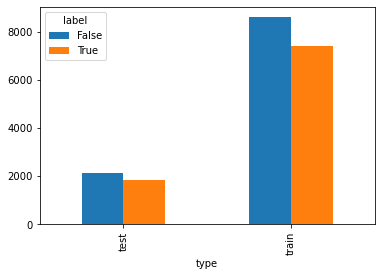

In [8]:
data_grouped = data.groupby(["type", "label"]).count()
data_grouped["fileName"].rename({"fileName": "count"}).unstack().plot(kind='bar')

#### Basic statistics about the bounding box area

In [31]:
data[["box_area", "imageWidth", "imageHeight"]].describe().round()

box_area  imageWidth  imageHeight
count   20000.0     20000.0      20000.0
mean     5250.0       199.0        203.0
std      5512.0        36.0         30.0
min      -100.0        70.0         58.0
25%      1155.0       168.0        179.0
50%      3480.0       224.0        224.0
75%      7480.0       224.0        224.0
max     49275.0       224.0        224.0

<AxesSubplot:title={'center':'Histogram Of box width'}, ylabel='Frequency'>

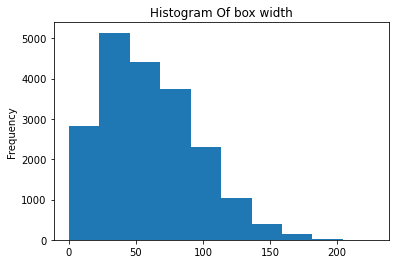

In [10]:
data["w"].plot.hist(title="Histogram Of box width")

<AxesSubplot:title={'center':'Histogram Of box height'}, ylabel='Frequency'>

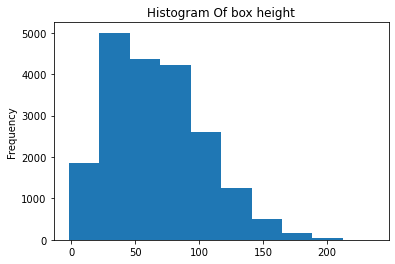

In [11]:
data["h"].plot.hist(title="Histogram Of box height")

From the statistics and graphs above we can see that -
- The data is splited to train - test with propotion of 75 % - 25 %.
- The classes are roughly balanced.
- The image sizes are not equal and there are in range of (58,70) - (224,224), but most of the images are close to the maximal size.
- When looking at the area of the bounding boxes (measured in pixels) we can see that there are images with illogical annotation bound box as we have negative values.
- Moreover, we can see that the maximum image size is (224,224) so the maximal area is 224*224=50176, so the biggest bounding box cover the hole image.

#### Sample of train images from the data

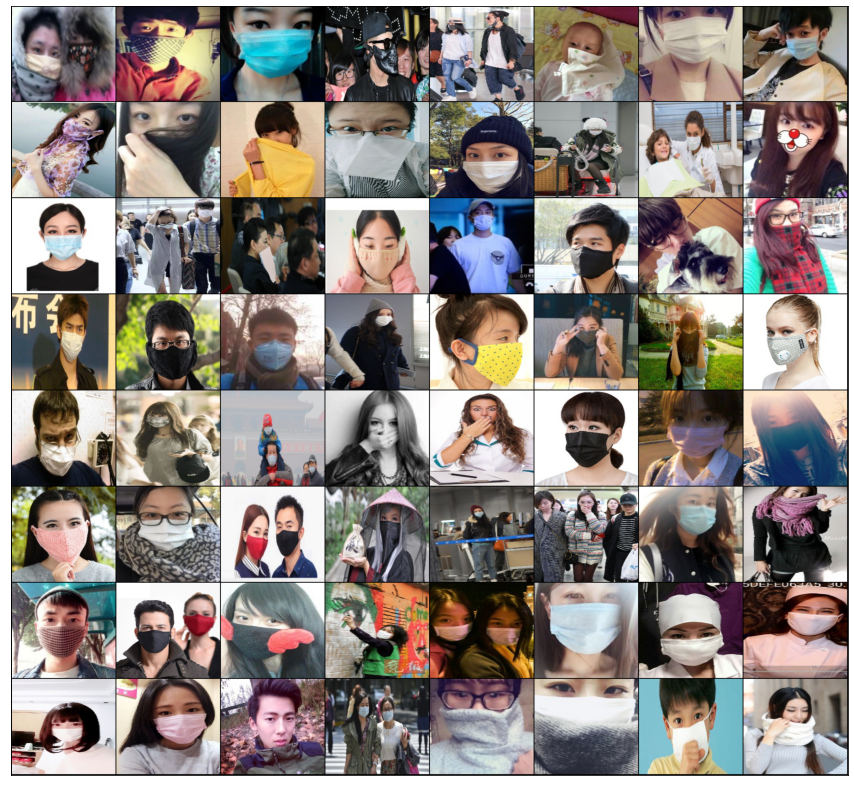

In [12]:
show_images(cfg.train_dir)

#### Sample of test images from the data

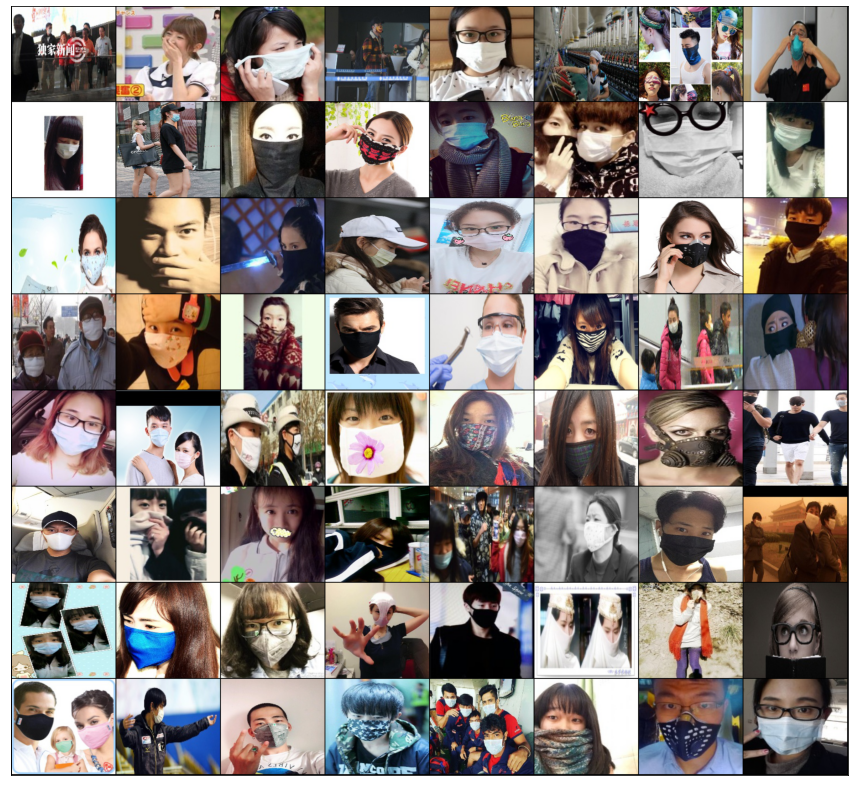

In [13]:
show_images(cfg.val_dir)

From the images above, that there are a lot of different images. The differences include - 
- The mask type.
- The object that is hidden and the object that obstructs.
- Zoom-in / Zoom-out.
- Number of people / objects in the image.
- Background.

#### Plot train images with bounding boxes - green proper mask, red for not proper mask

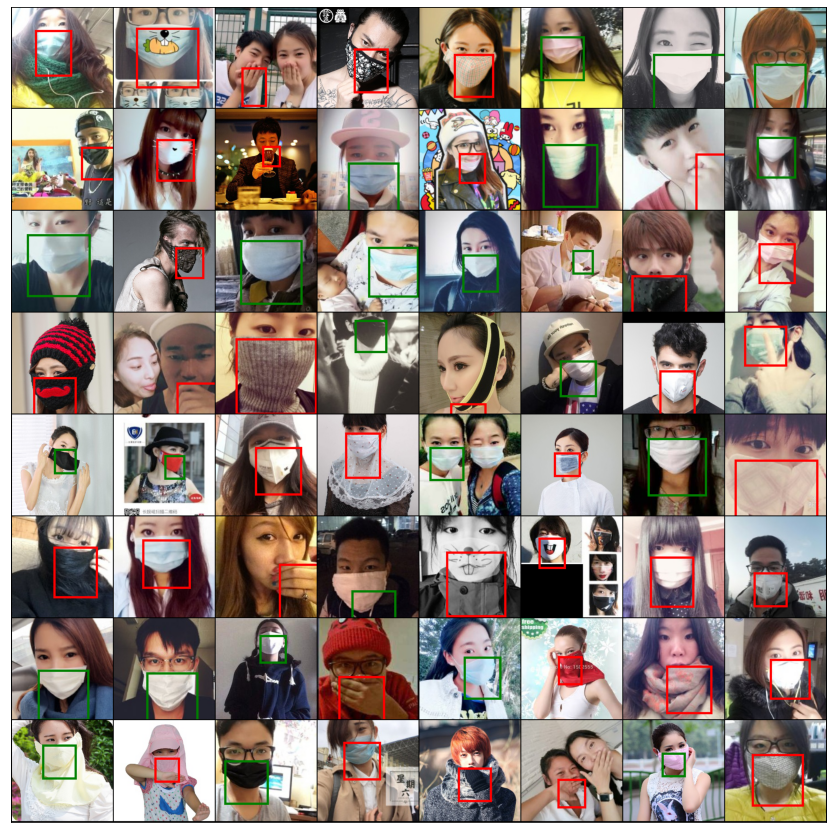

In [14]:
show_images_and_bboxes(cfg.train_dir)

####  Plot test images with bounding boxes -  green proper mask, red for not proper mask

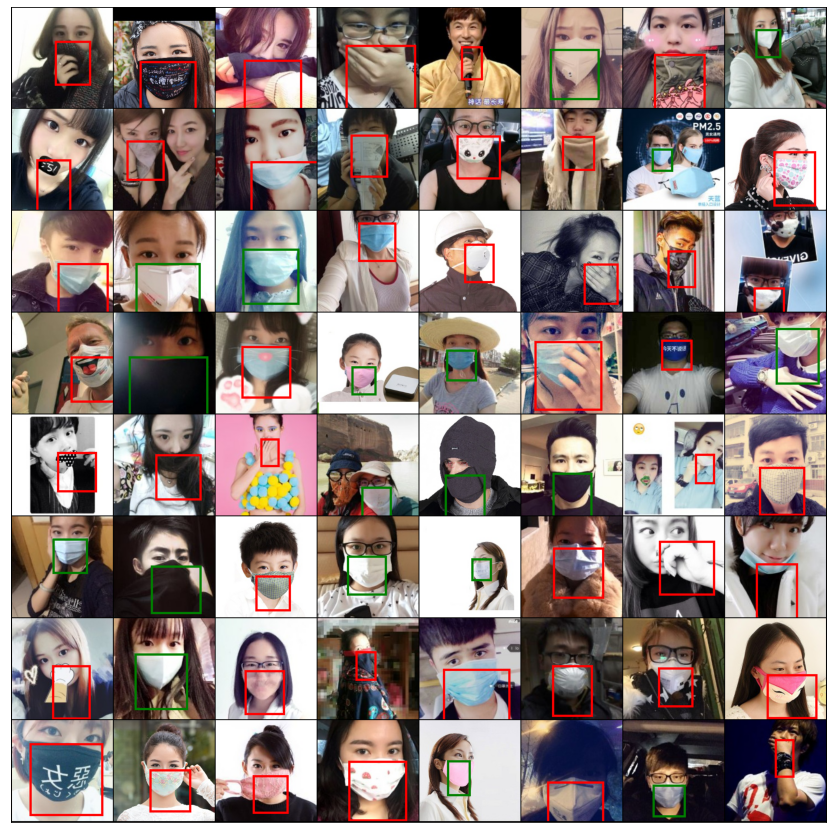

In [15]:
show_images_and_bboxes(cfg.val_dir)

From the images above, it seems that the annotations of the bounding boxes labels are according to the definition of proper mask. Although, the bounding boxes annotations are not perfect.

## Experiments

Throughout our work we make use of the [pytorch-lighting](https://www.pytorchlightning.ai/) framework, which abstracts away alot of the usual 'boilerplate' code that is usually involved in building & training neural networks. 

It wraps around the regular pytorch framework and makes it easy to use advanced features and to avoid mistakes. 

Additionally, we make use of [torchvision](https://pytorch.org/vision/stable/index.html) for handling the images.

### Data loading, pre-processing and cleaning

The cleaning and preprocessing steps we perform are rather simple -

First, we parse the image information (label & bounding box location) from the image file name.

The bounding boxes are defined as [$x_1$, $y_1$, $w$, $h$]. However, the model we use expects the bounding boxes to be in [$x_1$, $y_1$, $x_2$, $y_2$] format. Therefore we correct for this mismatch.

Before loading the images into the model, they are converted to a scale of [0,1].

We note that as the images are of different sizes, we create a custom collate function that handles this mismatch properly.

For loading the data into the model we make use of pytorch's *datasets* and *dataloaders* and of pytorch-lighting's 
*datamodule*. All these help to load the images efficiently into memory, when needed.

### Architecture

For the model architecture we chose to use the widely popular **Faster R-CNN**. 

It is a fast framework for object detection. that uses deep convolution networks. 

The architecture consists of three parts.

The first part extracts features from the raw image using a CNN module. 

In our case we use Resnet18 for this module. 

The second part is a Region Propoasl Network(RPN). 
This is is small neural network that goes over the last feature map of the previous module and predicts whether there is an object or not in that area, and if so, also the proposed bounding boxes. 

The third part uses a fully connected neural network, that takes as an input the regions proposed by the RPN and performs the predict object class ( classification) and Bounding boxes (Regression).


(describe fully and refer to original paper and code)

Fast R-CNN trains state-of-the-art models, like VGG16, 9x faster than traditional R-CNN.

### Loss Functions

### Optimizers

### Regularization

### Hyper parameter tuning

#### Train + Test loss graph

In [ ]:
# show graph here

#### Train + Test average accuracy graph

In [ ]:
# show graph here

#### Train + Test average IoU graph

In [ ]:
# show graph here